In [109]:
! pip install --quiet statsmodels optuna plotly


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import optuna

In [111]:
df_weather_hourly = pd.read_parquet(r'..\data\01_interim\weather_hourly_darksky_cleaned.parquet')

In [112]:
df_weather_hourly.head()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,day_of_week
time,,,,,,,,,,,
2011-11-01 00:00:00,13.63,160.0,13.49,11.48,1008.14,13.49,3.11,rain,clear-night,0.88,Tuesday
2011-11-01 00:30:00,13.44,157.0,13.11,11.53,1008.01,13.11,3.10,rain,clear-night,0.90,Tuesday
2011-11-01 01:00:00,13.26,154.0,12.73,11.58,1007.88,12.73,3.08,rain,partly-cloudy-night,0.93,Tuesday
2011-11-01 01:30:00,13.10,157.5,13.19,11.86,1007.48,13.19,3.40,rain,partly-cloudy-night,0.92,Tuesday
2011-11-01 02:00:00,12.94,161.0,13.65,12.14,1007.09,13.65,3.71,rain,clear-night,0.91,Tuesday


In [113]:
df_consumption_hourly = pd.read_parquet(r'..\data\02_processed\parquet\group_4_half_hourly.parquet')

In [114]:
df_consumption_hourly.head()

,Acorn,Acorn_grouped,DateTime,nb_clients,Conso_moy,Date
0,ACORN-P,Adversity,2012-06-30 22:00:00,86,0.101326,2012-06-30
1,ACORN-P,Adversity,2012-06-30 22:30:00,86,0.094907,2012-06-30
2,ACORN-P,Adversity,2012-06-30 23:00:00,86,0.104337,2012-06-30
3,ACORN-P,Adversity,2012-06-30 23:30:00,86,0.091849,2012-06-30
4,ACORN-P,Adversity,2012-07-01 00:00:00,86,0.070151,2012-07-01


In [115]:
df_consumption_hourly = df_consumption_hourly.drop(columns=['Date','Acorn_grouped'])

In [116]:
df = pd.merge(df_weather_hourly, df_consumption_hourly, left_index=True, right_on='DateTime').reset_index(drop=True)

In [117]:
period = df.DateTime.min(), df.DateTime.max()
print(f"Data period: {period[0]} to {period[1]}")

Data period: 2012-06-30 22:00:00 to 2014-01-12 23:30:00


In [118]:
test_percentage = 2/(period[1]-period[0]).days
test_percentage

0.0035650623885918

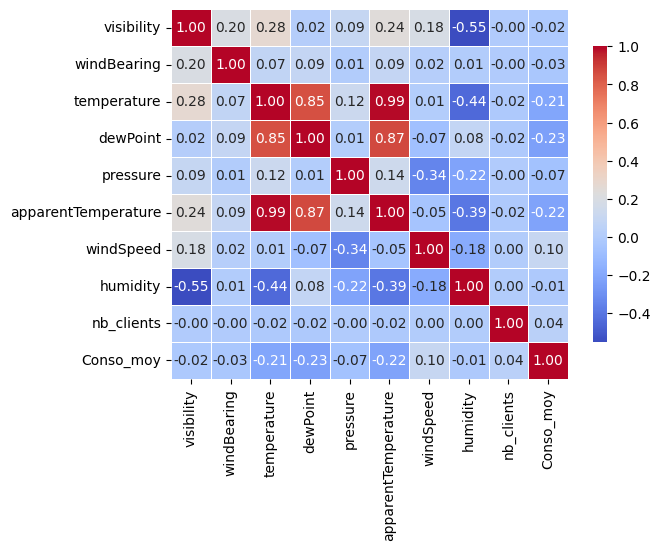

In [119]:
sns.heatmap(df.corr(numeric_only=True), 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            linewidths=0.5, 
            cbar_kws={"shrink": .8})
plt.show()

In [120]:
df = df.drop(columns='apparentTemperature')

In [121]:
df.head()

,visibility,windBearing,temperature,dewPoint,pressure,windSpeed,precipType,icon,humidity,day_of_week,Acorn,DateTime,nb_clients,Conso_moy
0,13.37,223.0,13.61,10.22,1010.79,4.80,rain,clear-night,0.8,Saturday,ACORN-P,2012-06-30 22:00:00,86,0.101326
1,13.37,223.0,13.61,10.22,1010.79,4.80,rain,clear-night,0.8,Saturday,ACORN-C,2012-06-30 22:00:00,74,0.260986
2,13.37,223.0,13.61,10.22,1010.79,4.80,rain,clear-night,0.8,Saturday,ACORN-F,2012-06-30 22:00:00,585,0.210542
3,13.66,224.5,13.54,10.24,1010.94,4.72,rain,clear-night,0.8,Saturday,ACORN-P,2012-06-30 22:30:00,86,0.094907
4,13.66,224.5,13.54,10.24,1010.94,4.72,rain,clear-night,0.8,Saturday,ACORN-C,2012-06-30 22:30:00,74,0.221784


In [122]:
holidays = pd.read_csv(r'..\data\00_raw\uk_bank_holidays.csv')
holidays.head()

,Bank holidays,Type
0,2012-12-26,Boxing Day
1,2012-12-25,Christmas Day
2,2012-08-27,Summer bank holiday
3,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)
4,2012-04-06,Spring bank holiday (substitute day)


In [123]:
holidays = pd.to_datetime(holidays['Bank holidays'])

In [124]:
df['is_holiday'] = df['DateTime'].dt.date.isin(holidays.dt.date)

In [125]:
# Extract hour, day of week, and month as numeric columns:
df["hour"]      = df["DateTime"].dt.hour
df["dayofweek"] = df["DateTime"].dt.dayofweek
df["month"]     = df["DateTime"].dt.month
df["dayofyear"] = df["DateTime"].dt.day_of_year
# Drop the original timestamp‐and‐DateTime columns if we only use the derived features:

In [126]:

# ──────────────────────────────────────────────────────────────────────────────
#  2)  SPLIT OUT THE FINAL 48 H (96 ROWS) PER ACORN GROUP AS A HOLD‐OUT TEST SET
# ──────────────────────────────────────────────────────────────────────────────

# 2.1) Create a “within‐group” index so we can count 96 rows from the end of each ACORN:
df = df.sort_values(["Acorn", "DateTime"]).reset_index(drop=True)
df["group_idx"] = df.groupby("Acorn").cumcount()

# 2.2) Find out how many rows remain in each ACORN (after sorting & resetting index):
group_sizes = {
    g: grp_df["group_idx"].max() + 1
    for g, grp_df in df.groupby("Acorn")
}

# 2.3) Mark the final 96 rows of each ACORN as “test,” everything before as “train”
horizon_steps = 48 * 2  # 48 hours × 2 half‐hours/hour = 96
def mark_test(row):
    ac = row["Acorn"]
    Ni = group_sizes[ac]
    # If group_idx >= Ni − 96 → test; else → train
    return row["group_idx"] >= (Ni - horizon_steps)

df["is_test"] = df.apply(mark_test, axis=1)

# 2.4) Split into train vs. test DataFrames:
df_train = df[~df["is_test"]].copy()
df_test  = df[df["is_test"]].copy()

print(f"Total rows overall: {len(df)}")
print(f" → Training rows: {len(df_train)}")
print(f" →   Test rows: {len(df_test)}   (this is exactly 96 × #ACORN groups)")
print()

# For reference:
#   If you have 3 ACORN groups and each has, say, 27 000 rows, then 
#   test_rows = 96 × 3 = 288, and train_rows = 27 000×3 − 288, etc.


# ──────────────────────────────────────────────────────────────────────────────
#  3)  EXTRACT X_train, y_train, X_test, y_test
# ──────────────────────────────────────────────────────────────────────────────

# 3.1) Our target is the “current” consumption at that half‐hour:
y_train = df_train["Conso_moy"].astype(float)
y_test  = df_test["Conso_moy"].astype(float)

# 3.2) Build X_train / X_test by dropping the target + auxiliary columns:
drop_cols = [
    "Conso_moy",   # the target itself
    "group_idx",   # just used for indexing
    "is_test",     # train/test flag
]
X_train = df_train.drop(columns=drop_cols)
X_test  = df_test.drop(columns=drop_cols)

print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test  shape:", y_test.shape)
print()


# ──────────────────────────────────────────────────────────────────────────────
#  4)  BUILD A KNN PIPELINE THAT PREDICTS Conso_moy_i FROM weather_i (and time_i, Acorn)
# ──────────────────────────────────────────────────────────────────────────────

# 4.1) Convert boolean "is_holiday" → integer 0/1
X_train["is_holiday"] = X_train["is_holiday"].astype(int)
X_test ["is_holiday"] = X_test ["is_holiday"].astype(int)

# 4.2) Identify numeric vs. categorical features:
numeric_features = [
    "visibility",
    "windBearing",
    "temperature",
    "dewPoint",
    "pressure",
    "windSpeed",
    "humidity",
    "nb_clients",
    "hour",
    "dayofweek",
    "month",
    "is_holiday",
    "dayofyear"
]

categorical_features = [
    "precipType",
    "icon",
    "Acorn",
]

# 4.3) Create a ColumnTransformer to scale numeric features and one‐hot encode categoricals:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop"  # drop anything not listed above
)

Total rows overall: 80796
 → Training rows: 80508
 →   Test rows: 288   (this is exactly 96 × #ACORN groups)

X_train shape: (80508, 18)
X_test  shape: (288, 18)
y_train shape: (80508,)
y_test  shape: (288,)



### First test KNN

Total rows overall: 80796
 → Training rows: 80508
 →   Test rows: 288   (this is exactly 96 × #ACORN groups)

X_train shape: (80508, 18)
X_test  shape: (288, 18)
y_train shape: (80508,)
y_test  shape: (288,)

Pipeline has been fit on all data *before* the final 48 h of each ACORN.

FINAL 48 h Forecast Evaluation—All ACORN groups combined:
  Test RMSE = 0.0731
  Test MAE  = 0.0486



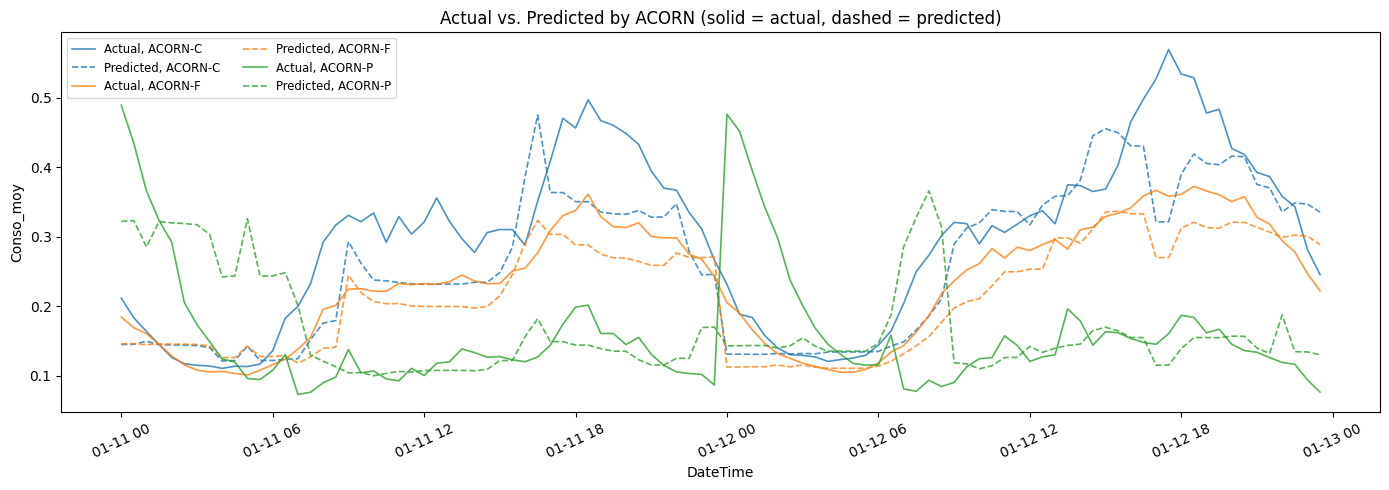

Visualizing full history for ACORN = ACORN-C



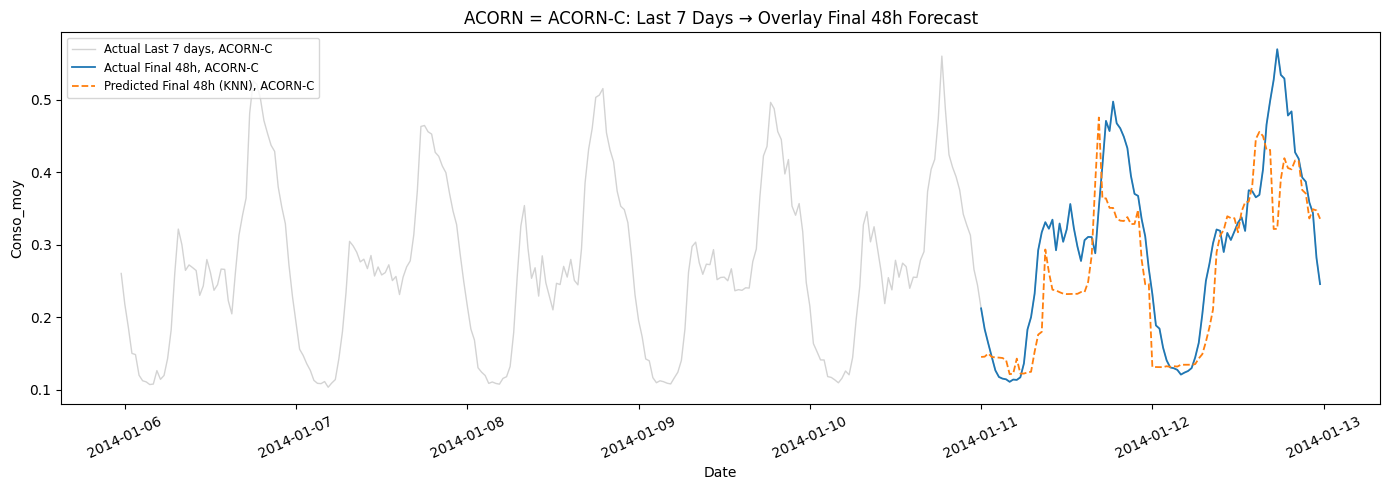

In [18]:


# 4.4) Build the KNN regressor (you can change n_neighbors later or tune via Optuna)
n_neighbors = 5
knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights="distance", p=2)

pipeline = Pipeline(
    steps=[
        ("preproc", preprocessor),
        ("knn", knn),
    ]
)


# ──────────────────────────────────────────────────────────────────────────────
#  5)  FIT THE PIPELINE ON ALL HISTORICAL DATA (up to t) – that is, X_train / y_train
# ──────────────────────────────────────────────────────────────────────────────

pipeline.fit(X_train, y_train)
print("Pipeline has been fit on all data *before* the final 48 h of each ACORN.")
print()


# ──────────────────────────────────────────────────────────────────────────────
#  6)  PREDICT ON THE HELD‐OUT 48 H (t → t+48 h) FOR EACH ACORN GROUP
# ──────────────────────────────────────────────────────────────────────────────

# 6.1) The test‐set X_test consists of “weather_i & other features @ time i” 
#      for i in that final 48 h of each ACORN.  We simply do:
y_pred_test = pipeline.predict(X_test)

# 6.2) Compute RMSE / MAE on this test‐set:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae  = mean_absolute_error(y_test, y_pred_test)
print(f"FINAL 48 h Forecast Evaluation—All ACORN groups combined:")
print(f"  Test RMSE = {rmse:.4f}")
print(f"  Test MAE  = {mae:.4f}")
print()


# ──────────────────────────────────────────────────────────────────────────────
#  7)  PLOTTING
#     A) Zoom in on the last 48 h: show actual vs. predicted with real timestamps
#     B) Show the entire historical consumption series for one ACORN, then overlay its final 48 h forecast
# ──────────────────────────────────────────────────────────────────────────────

# 7.A) ZOOM IN ON LAST 48 H (ALL ACORN GROUPS INTERLEAVED)
#      But to keep the x‐axis tidy, we’ll plot each ACORN separately or overlay them with distinct colors.
#
#      First, compute the “target timestamps” that correspond to these predictions.
#      Remember: X_test["DateTime"] is the half‐hour time at which we are “forecasting.”
#      But since our model is “predict Conso_moy @ that same time,” there is no +48h shift in plotting.
#      In other words: to forecast consumption at time i, we used weather @ time i.
#
#      So when we plot actual vs. predicted, the timestamp is simply X_test["DateTime"] itself.

df_test["y_pred"] = y_pred_test  # attach the predictions so we can group‐by‐Acorn for plotting

plt.figure(figsize=(14, 5))
ax = plt.gca()

for acorn_label, grp in df_test.groupby("Acorn"):
    # 1) Plot the “Actual” curve and capture the Line2D object it returns:
    actual_line, = ax.plot(
        grp["DateTime"],
        grp["Conso_moy"],
        label=f"Actual, {acorn_label}",
        linewidth=1.2,
        alpha=0.8
    )
    # 2) Find out which color matplotlib chose for that “Actual” line:
    the_color = actual_line.get_color()

    # 3) Plot the “Predicted” curve using the same color but a dashed linestyle:
    ax.plot(
        grp["DateTime"],
        grp["y_pred"],
        color=the_color,       # reuse the exact same color
        linestyle="--",        # change only the linestyle
        label=f"Predicted, {acorn_label}",
        linewidth=1.2,
        alpha=0.8
    )

ax.set_xlabel("DateTime")
ax.set_ylabel("Conso_moy")
ax.set_title("Actual vs. Predicted by ACORN (solid = actual, dashed = predicted)")
ax.legend(ncol=2, fontsize="small", loc="upper left")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()


# 7.B) FULL‐HISTORY PLOT FOR A SINGLE ACORN GROUP
#      Let’s choose one ACORN (e.g. the first unique value) so we can clearly see how the final 48 h “sits” at the end.

one_acorn = df["Acorn"].unique()[0]  
print(f"Visualizing full history for ACORN = {one_acorn}\n")

full_group = df[df["Acorn"] == one_acorn].sort_values("DateTime").reset_index(drop=True)

# 3) Find the most recent timestamp in that group
last_timestamp = full_group["DateTime"].max()

# 4) Compute one week ago from that timestamp
one_week_ago = last_timestamp - pd.Timedelta(days=7)

# 5) Filter down to just the final 7 days
last_week_df = full_group[full_group["DateTime"] >= one_week_ago].reset_index(drop=True)

# 6) From df_test, pick out this ACORN’s final 48h rows and sort by DateTime
last48 = df_test[df_test["Acorn"] == one_acorn].sort_values("DateTime").reset_index(drop=True)

# 7) Plot
plt.figure(figsize=(14, 5))

# 7A) Actual last 7 days (light gray)
plt.plot(
    last_week_df["DateTime"],
    last_week_df["Conso_moy"],
    color="lightgray",
    linewidth=1.0,
    label=f"Actual Last 7 days, {one_acorn}"
)

# 7B) Actual final 48h (solid blue)
plt.plot(
    last48["DateTime"],
    last48["Conso_moy"],
    color="C0",
    linewidth=1.3,
    label=f"Actual Final 48h, {one_acorn}"
)

# 7C) Predicted final 48h (dashed orange)
plt.plot(
    last48["DateTime"],
    last48["y_pred"],
    color="C1",
    linestyle="--",
    linewidth=1.3,
    label=f"Predicted Final 48h (KNN), {one_acorn}"
)

plt.xlabel("Date")
plt.ylabel("Conso_moy")
plt.title(f"ACORN = {one_acorn}: Last 7 Days → Overlay Final 48h Forecast")
plt.legend(fontsize="small", loc="upper left")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()


### hyperparameter tuning KNN

[I 2025-06-05 01:07:29,798] A new study created in memory with name: knn_current‐timestamp_forecast
Best trial: 0. Best value: 0.0959911:   2%|▏         | 1/50 [00:18<15:20, 18.78s/it]

[I 2025-06-05 01:07:48,579] Trial 0 finished with value: 0.09599107995408192 and parameters: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 41}. Best is trial 0 with value: 0.09599107995408192.


Best trial: 1. Best value: 0.0837503:   4%|▍         | 2/50 [00:35<14:08, 17.69s/it]

[I 2025-06-05 01:08:05,501] Trial 1 finished with value: 0.0837502921562594 and parameters: {'algorithm': 'auto', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 88, 'weights': 'uniform', 'leaf_size': 11}. Best is trial 1 with value: 0.0837502921562594.


Best trial: 1. Best value: 0.0837503:   6%|▌         | 3/50 [00:52<13:24, 17.12s/it]

[I 2025-06-05 01:08:21,951] Trial 2 finished with value: 0.08720256616155865 and parameters: {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 47, 'weights': 'distance', 'leaf_size': 16}. Best is trial 1 with value: 0.0837502921562594.


Best trial: 1. Best value: 0.0837503:   8%|▊         | 4/50 [01:25<18:01, 23.51s/it]

[I 2025-06-05 01:08:55,244] Trial 3 finished with value: 0.10701759873338862 and parameters: {'algorithm': 'auto', 'metric': 'chebyshev', 'n_neighbors': 48, 'weights': 'distance', 'leaf_size': 35}. Best is trial 1 with value: 0.0837502921562594.


Best trial: 1. Best value: 0.0837503:  10%|█         | 5/50 [01:31<12:57, 17.27s/it]

[I 2025-06-05 01:09:01,469] Trial 4 finished with value: 0.09415729924175899 and parameters: {'algorithm': 'brute', 'metric': 'euclidean', 'n_neighbors': 87, 'weights': 'uniform', 'leaf_size': 23}. Best is trial 1 with value: 0.0837502921562594.


Best trial: 1. Best value: 0.0837503:  12%|█▏        | 6/50 [01:37<09:45, 13.30s/it]

[I 2025-06-05 01:09:07,045] Trial 5 finished with value: 0.10011137307523228 and parameters: {'algorithm': 'auto', 'metric': 'minkowski', 'p': 2, 'n_neighbors': 15, 'weights': 'distance', 'leaf_size': 29}. Best is trial 1 with value: 0.0837502921562594.


Best trial: 1. Best value: 0.0837503:  14%|█▍        | 7/50 [01:45<08:17, 11.58s/it]

[I 2025-06-05 01:09:15,081] Trial 6 finished with value: 0.09738741217120324 and parameters: {'algorithm': 'kd_tree', 'metric': 'minkowski', 'p': 2, 'n_neighbors': 31, 'weights': 'distance', 'leaf_size': 47}. Best is trial 1 with value: 0.0837502921562594.


Best trial: 1. Best value: 0.0837503:  16%|█▌        | 8/50 [02:00<08:59, 12.84s/it]

[I 2025-06-05 01:09:30,633] Trial 7 finished with value: 0.09041966741781622 and parameters: {'algorithm': 'brute', 'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'uniform', 'leaf_size': 16}. Best is trial 1 with value: 0.0837502921562594.


Best trial: 8. Best value: 0.0837162:  18%|█▊        | 9/50 [02:52<17:02, 24.93s/it]

[I 2025-06-05 01:10:22,138] Trial 8 finished with value: 0.08371617828001805 and parameters: {'algorithm': 'kd_tree', 'metric': 'manhattan', 'n_neighbors': 89, 'weights': 'uniform', 'leaf_size': 13}. Best is trial 8 with value: 0.08371617828001805.


Best trial: 8. Best value: 0.0837162:  20%|██        | 10/50 [04:28<31:14, 46.87s/it]

[I 2025-06-05 01:11:58,130] Trial 9 finished with value: 0.12463615437129116 and parameters: {'algorithm': 'ball_tree', 'metric': 'chebyshev', 'n_neighbors': 40, 'weights': 'distance', 'leaf_size': 17}. Best is trial 8 with value: 0.08371617828001805.


Best trial: 8. Best value: 0.0837162:  22%|██▏       | 11/50 [04:53<26:09, 40.24s/it]

[I 2025-06-05 01:12:23,345] Trial 10 finished with value: 0.09474667494501 and parameters: {'algorithm': 'kd_tree', 'metric': 'euclidean', 'n_neighbors': 69, 'weights': 'uniform', 'leaf_size': 51}. Best is trial 8 with value: 0.08371617828001805.


Best trial: 11. Best value: 0.083433:  24%|██▍       | 12/50 [05:53<29:20, 46.33s/it]

[I 2025-06-05 01:13:23,579] Trial 11 finished with value: 0.08343302747206005 and parameters: {'algorithm': 'kd_tree', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 99, 'weights': 'uniform', 'leaf_size': 10}. Best is trial 11 with value: 0.08343302747206005.


Best trial: 11. Best value: 0.083433:  26%|██▌       | 13/50 [06:47<29:58, 48.61s/it]

[I 2025-06-05 01:14:17,475] Trial 12 finished with value: 0.08345845747930929 and parameters: {'algorithm': 'kd_tree', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 98, 'weights': 'uniform', 'leaf_size': 59}. Best is trial 11 with value: 0.08343302747206005.


Best trial: 13. Best value: 0.0834028:  28%|██▊       | 14/50 [07:07<24:01, 40.04s/it]

[I 2025-06-05 01:14:37,697] Trial 13 finished with value: 0.08340279497456932 and parameters: {'algorithm': 'kd_tree', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 100, 'weights': 'uniform', 'leaf_size': 60}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  30%|███       | 15/50 [07:26<19:30, 33.44s/it]

[I 2025-06-05 01:14:55,835] Trial 14 finished with value: 0.08448267382243392 and parameters: {'algorithm': 'kd_tree', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 68, 'weights': 'uniform', 'leaf_size': 60}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  32%|███▏      | 16/50 [07:43<16:09, 28.52s/it]

[I 2025-06-05 01:15:12,932] Trial 15 finished with value: 0.08439873139778752 and parameters: {'algorithm': 'kd_tree', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 70, 'weights': 'uniform', 'leaf_size': 28}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  34%|███▍      | 17/50 [08:02<14:12, 25.84s/it]

[I 2025-06-05 01:15:32,529] Trial 16 finished with value: 0.08348950007804679 and parameters: {'algorithm': 'kd_tree', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 97, 'weights': 'uniform', 'leaf_size': 52}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  36%|███▌      | 18/50 [08:18<12:13, 22.93s/it]

[I 2025-06-05 01:15:48,689] Trial 17 finished with value: 0.08411366640974656 and parameters: {'algorithm': 'kd_tree', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 77, 'weights': 'uniform', 'leaf_size': 39}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  38%|███▊      | 19/50 [08:23<09:03, 17.52s/it]

[I 2025-06-05 01:15:53,621] Trial 18 finished with value: 0.09437281550436655 and parameters: {'algorithm': 'brute', 'metric': 'euclidean', 'n_neighbors': 80, 'weights': 'uniform', 'leaf_size': 25}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  40%|████      | 20/50 [09:21<14:48, 29.60s/it]

[I 2025-06-05 01:16:51,380] Trial 19 finished with value: 0.11361201022210948 and parameters: {'algorithm': 'ball_tree', 'metric': 'chebyshev', 'n_neighbors': 54, 'weights': 'uniform', 'leaf_size': 33}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  42%|████▏     | 21/50 [09:31<11:27, 23.72s/it]

[I 2025-06-05 01:17:01,385] Trial 20 finished with value: 0.09499994076817357 and parameters: {'algorithm': 'kd_tree', 'metric': 'minkowski', 'p': 2, 'n_neighbors': 63, 'weights': 'uniform', 'leaf_size': 44}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  44%|████▍     | 22/50 [10:10<13:12, 28.29s/it]

[I 2025-06-05 01:17:40,343] Trial 21 finished with value: 0.08340279497456932 and parameters: {'algorithm': 'kd_tree', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 100, 'weights': 'uniform', 'leaf_size': 60}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  46%|████▌     | 23/50 [10:30<11:39, 25.89s/it]

[I 2025-06-05 01:18:00,634] Trial 22 finished with value: 0.08345845747930929 and parameters: {'algorithm': 'kd_tree', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 98, 'weights': 'uniform', 'leaf_size': 55}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  48%|████▊     | 24/50 [10:49<10:20, 23.85s/it]

[I 2025-06-05 01:18:19,714] Trial 23 finished with value: 0.08400779921745054 and parameters: {'algorithm': 'kd_tree', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 80, 'weights': 'uniform', 'leaf_size': 55}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  50%|█████     | 25/50 [10:53<07:25, 17.82s/it]

[I 2025-06-05 01:18:23,472] Trial 24 finished with value: 0.10989496458523369 and parameters: {'algorithm': 'kd_tree', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 47}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  52%|█████▏    | 26/50 [11:14<07:31, 18.83s/it]

[I 2025-06-05 01:18:44,640] Trial 25 finished with value: 0.08340279497456932 and parameters: {'algorithm': 'kd_tree', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 100, 'weights': 'uniform', 'leaf_size': 56}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  54%|█████▍    | 27/50 [11:34<07:22, 19.23s/it]

[I 2025-06-05 01:19:04,791] Trial 26 finished with value: 0.08368984869582718 and parameters: {'algorithm': 'kd_tree', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 90, 'weights': 'uniform', 'leaf_size': 56}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  56%|█████▌    | 28/50 [12:08<08:36, 23.47s/it]

[I 2025-06-05 01:19:38,177] Trial 27 finished with value: 0.10670576706087709 and parameters: {'algorithm': 'brute', 'metric': 'chebyshev', 'n_neighbors': 92, 'weights': 'uniform', 'leaf_size': 60}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  58%|█████▊    | 29/50 [12:35<08:34, 24.51s/it]

[I 2025-06-05 01:20:05,097] Trial 28 finished with value: 0.09437281550436655 and parameters: {'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 80, 'weights': 'uniform', 'leaf_size': 51}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  60%|██████    | 30/50 [12:49<07:11, 21.56s/it]

[I 2025-06-05 01:20:19,796] Trial 29 finished with value: 0.08486324653436605 and parameters: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 84, 'weights': 'distance', 'leaf_size': 41}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  62%|██████▏   | 31/50 [13:08<06:30, 20.56s/it]

[I 2025-06-05 01:20:38,029] Trial 30 finished with value: 0.08480607405416167 and parameters: {'algorithm': 'kd_tree', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 62, 'weights': 'uniform', 'leaf_size': 57}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  64%|██████▍   | 32/50 [13:30<06:16, 20.94s/it]

[I 2025-06-05 01:20:59,839] Trial 31 finished with value: 0.08343302747206005 and parameters: {'algorithm': 'kd_tree', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 99, 'weights': 'uniform', 'leaf_size': 53}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  66%|██████▌   | 33/50 [14:20<08:28, 29.94s/it]

[I 2025-06-05 01:21:50,762] Trial 32 finished with value: 0.08360626654669522 and parameters: {'algorithm': 'kd_tree', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 93, 'weights': 'uniform', 'leaf_size': 48}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  68%|██████▊   | 34/50 [15:02<08:54, 33.41s/it]

[I 2025-06-05 01:22:32,275] Trial 33 finished with value: 0.08357335496246654 and parameters: {'algorithm': 'kd_tree', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 94, 'weights': 'uniform', 'leaf_size': 57}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  70%|███████   | 35/50 [15:15<06:50, 27.38s/it]

[I 2025-06-05 01:22:45,591] Trial 34 finished with value: 0.08340279497456932 and parameters: {'algorithm': 'auto', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 100, 'weights': 'uniform', 'leaf_size': 21}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  72%|███████▏  | 36/50 [15:29<05:27, 23.40s/it]

[I 2025-06-05 01:22:59,714] Trial 35 finished with value: 0.08486324653436605 and parameters: {'algorithm': 'auto', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 84, 'weights': 'distance', 'leaf_size': 21}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  74%|███████▍  | 37/50 [15:43<04:24, 20.33s/it]

[I 2025-06-05 01:23:12,859] Trial 36 finished with value: 0.08418779909396566 and parameters: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 75, 'weights': 'uniform', 'leaf_size': 32}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  76%|███████▌  | 38/50 [15:47<03:08, 15.70s/it]

[I 2025-06-05 01:23:17,775] Trial 37 finished with value: 0.0944416506108093 and parameters: {'algorithm': 'auto', 'metric': 'minkowski', 'p': 2, 'n_neighbors': 86, 'weights': 'distance', 'leaf_size': 37}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  78%|███████▊  | 39/50 [16:15<03:30, 19.18s/it]

[I 2025-06-05 01:23:45,059] Trial 38 finished with value: 0.10720216185647675 and parameters: {'algorithm': 'auto', 'metric': 'chebyshev', 'n_neighbors': 100, 'weights': 'uniform', 'leaf_size': 43}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  80%|████████  | 40/50 [16:20<02:29, 14.95s/it]

[I 2025-06-05 01:23:50,133] Trial 39 finished with value: 0.09402311252757589 and parameters: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 92, 'weights': 'uniform', 'leaf_size': 49}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  82%|████████▏ | 41/50 [16:33<02:09, 14.38s/it]

[I 2025-06-05 01:24:03,187] Trial 40 finished with value: 0.08919895788517594 and parameters: {'algorithm': 'brute', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 31, 'weights': 'distance', 'leaf_size': 58}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  84%|████████▍ | 42/50 [16:57<02:19, 17.42s/it]

[I 2025-06-05 01:24:27,712] Trial 41 finished with value: 0.08354487984523014 and parameters: {'algorithm': 'kd_tree', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 95, 'weights': 'uniform', 'leaf_size': 10}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  86%|████████▌ | 43/50 [17:16<02:04, 17.72s/it]

[I 2025-06-05 01:24:46,134] Trial 42 finished with value: 0.08368984869582718 and parameters: {'algorithm': 'ball_tree', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 90, 'weights': 'uniform', 'leaf_size': 19}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  88%|████████▊ | 44/50 [17:34<01:47, 17.93s/it]

[I 2025-06-05 01:25:04,543] Trial 43 finished with value: 0.08388000516717475 and parameters: {'algorithm': 'kd_tree', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 84, 'weights': 'uniform', 'leaf_size': 25}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  90%|█████████ | 45/50 [17:48<01:23, 16.79s/it]

[I 2025-06-05 01:25:18,692] Trial 44 finished with value: 0.08340279497456932 and parameters: {'algorithm': 'auto', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 100, 'weights': 'uniform', 'leaf_size': 12}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  92%|█████████▏| 46/50 [18:03<01:04, 16.04s/it]

[I 2025-06-05 01:25:32,964] Trial 45 finished with value: 0.0837502921562594 and parameters: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 88, 'weights': 'uniform', 'leaf_size': 13}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  94%|█████████▍| 47/50 [18:17<00:46, 15.51s/it]

[I 2025-06-05 01:25:47,259] Trial 46 finished with value: 0.08340279497456932 and parameters: {'algorithm': 'auto', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 100, 'weights': 'uniform', 'leaf_size': 16}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  96%|█████████▌| 48/50 [18:32<00:30, 15.25s/it]

[I 2025-06-05 01:26:01,904] Trial 47 finished with value: 0.08354487984523014 and parameters: {'algorithm': 'auto', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 95, 'weights': 'uniform', 'leaf_size': 13}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028:  98%|█████████▊| 49/50 [18:47<00:15, 15.18s/it]

[I 2025-06-05 01:26:16,902] Trial 48 finished with value: 0.08527000436538806 and parameters: {'algorithm': 'auto', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 74, 'weights': 'distance', 'leaf_size': 60}. Best is trial 13 with value: 0.08340279497456932.


Best trial: 13. Best value: 0.0834028: 100%|██████████| 50/50 [19:17<00:00, 23.14s/it]


[I 2025-06-05 01:26:46,842] Trial 49 finished with value: 0.10667389786032294 and parameters: {'algorithm': 'auto', 'metric': 'chebyshev', 'n_neighbors': 88, 'weights': 'uniform', 'leaf_size': 53}. Best is trial 13 with value: 0.08340279497456932.
─────────────────────────────────────────────
Optuna best parameters for KNN (weather_i → cons_i):
{'algorithm': 'kd_tree', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 100, 'weights': 'uniform', 'leaf_size': 60}
  → Best CV‐RMSE = 0.0834
─────────────────────────────────────────────

─────────────────────────────────────────────
FINAL EVALUATION on Held‐Out 48 h (All ACORN groups):
  Test RMSE = 0.0662
  Test MAE  = 0.0461
─────────────────────────────────────────────



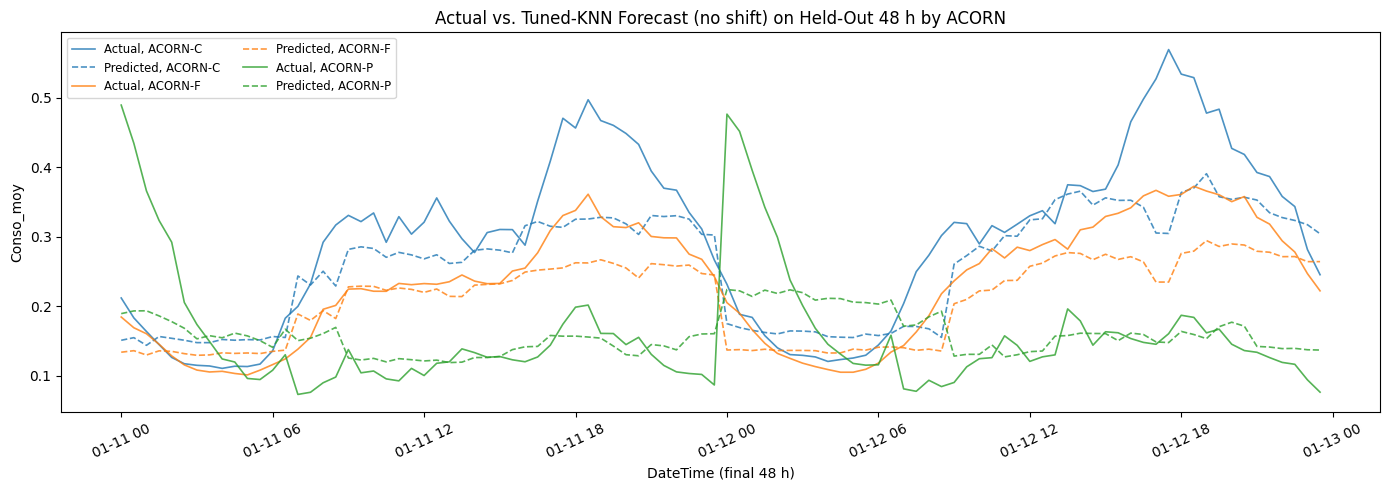

In [ ]:
# 4.2) Identify numeric vs. categorical features:
numeric_features = [
    "visibility", "windBearing", "temperature", "dewPoint", "pressure",
    "windSpeed", "humidity", "nb_clients", "hour", "dayofweek", "month", "dayofyear",
    "is_holiday",
]

categorical_features = [
    "precipType", "icon", "Acorn",
]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop"
)

# 4.3) We will let Optuna choose KNN’s hyperparameters (n_neighbors, weights, p):
#      As a placeholder, build a generic pipeline:
placeholder_knn = KNeighborsRegressor()
base_pipeline  = Pipeline(
    steps=[
        ("preproc", preprocessor),
        ("knn", placeholder_knn),
    ]
)


# ──────────────────────────────────────────────────────────────────────────────
#  5)  OPTUNA OBJECTIVE (CV ON TRAINING DATA ONLY)
# ──────────────────────────────────────────────────────────────────────────────
def objective(trial):
    # 1) Choose algorithm (which neighbor‐search)
    algorithm = trial.suggest_categorical(
        "algorithm", 
        ["auto", "ball_tree", "kd_tree", "brute"]
    )

    # 2) Choose distance metric
    metric = trial.suggest_categorical(
        "metric", 
        ["euclidean", "manhattan", "chebyshev", "minkowski"]
    )

    # 3) If using “minkowski,” tune p; otherwise ignore p
    if metric == "minkowski":
        p = trial.suggest_int("p", 1, 2)
    else:
        p = 2  # dummy; p is only used when metric="minkowski"

    # 4) Number of neighbors
    n_neighbors = trial.suggest_int("n_neighbors", 1, 100)

    # 5) Weighting
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])

    # 6) leaf_size (for tree construction)
    leaf_size = trial.suggest_int("leaf_size", 10, 60)

    # 7) Build the regressor with these hyperparameters
    knn = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        leaf_size=leaf_size,
        metric=metric,
        p=p
    )

    # 8) Put into the same preprocessing pipeline from before
    pipe = Pipeline([
        ("preproc", preprocessor),
        ("knn", knn)
    ])

    # 9) Evaluate via 3‐fold TimeSeriesSplit on X_train, y_train
    tscv = TimeSeriesSplit(n_splits=3)
    neg_mse = cross_val_score(
        pipe,
        X_train,
        y_train,
        cv=tscv,
        scoring="neg_mean_squared_error",
        n_jobs=-1
    )
    rmse_scores = np.sqrt(-neg_mse)

    return float(np.mean(rmse_scores))



# 5.6) Create and run the study
study = optuna.create_study(
    direction="minimize",
    study_name="knn_current‐timestamp_forecast"
)
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("─────────────────────────────────────────────")
print("Optuna best parameters for KNN (weather_i → cons_i):")
print(study.best_params)
print(f"  → Best CV‐RMSE = {study.best_value:.4f}")
print("─────────────────────────────────────────────\n")


─────────────────────────────────────────────
FINAL EVALUATION on Held‐Out 48 h (All ACORN groups):
  Test RMSE = 0.0662
  Test MAE  = 0.0461
─────────────────────────────────────────────



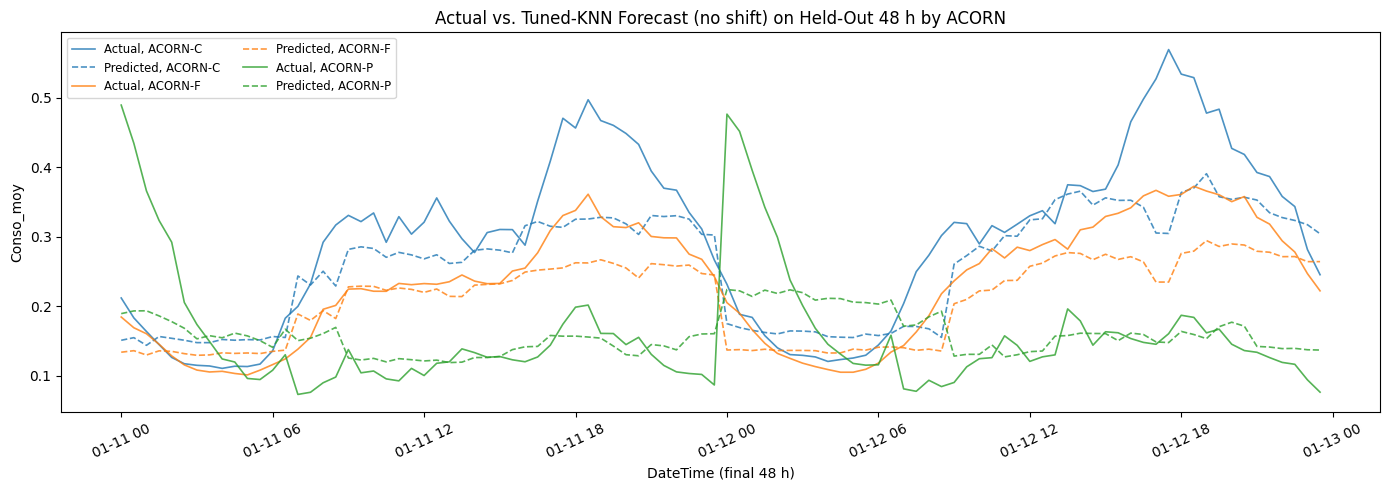

In [126]:
# ──────────────────────────────────────────────────────────────────────────────
#  6)  RETRAIN “BEST” PIPELINE ON FULL TRAIN SET, THEN EVALUATE ON FINAL 48 h
# ──────────────────────────────────────────────────────────────────────────────

best_algo = study.best_params["algorithm"]
best_metric = study.best_params["metric"]
best_leaf_size = study.best_params["leaf_size"]
best_nbr = study.best_params["n_neighbors"]
best_wts = study.best_params["weights"]
best_p   = study.best_params["p"]

# 6.1) Build a pipeline with those best params:
best_knn = KNeighborsRegressor(
    algorithm=best_algo,
    n_neighbors=best_nbr,
    weights=best_wts,
    p=best_p,
    metric=best_metric,
    leaf_size=best_leaf_size
)
best_pipeline = Pipeline([
    ("preproc", preprocessor),
    ("knn", best_knn),
])

# 6.2) Fit on the entire training set (all but last 96 per ACORN):
best_pipeline.fit(X_train, y_train)

# 6.3) Predict on the held‐out 48 h:
y_pred_test = best_pipeline.predict(X_test)

# 6.4) Compute final RMSE / MAE on that test set:
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae  = mean_absolute_error(y_test, y_pred_test)

print("─────────────────────────────────────────────")
print("FINAL EVALUATION on Held‐Out 48 h (All ACORN groups):")
print(f"  Test RMSE = {test_rmse:.4f}")
print(f"  Test MAE  = {test_mae:.4f}")
print("─────────────────────────────────────────────\n")


# ──────────────────────────────────────────────────────────────────────────────
#  7) OPTIONAL: PLOT THE HELD‐OUT 48 h BY ACORN (solid = actual, dashed = predicted)
# ──────────────────────────────────────────────────────────────────────────────

df_test["y_pred"] = y_pred_test

plt.figure(figsize=(14, 5))
for acorn_label, grp in df_test.groupby("Acorn"):
    actual_line, = plt.plot(
        grp["DateTime"],
        grp["Conso_moy"],
        label=f"Actual, {acorn_label}",
        linewidth=1.2,
        alpha=0.8
    )
    this_color = actual_line.get_color()
    plt.plot(
        grp["DateTime"],
        grp["y_pred"],
        color=this_color,
        linestyle="--",
        label=f"Predicted, {acorn_label}",
        linewidth=1.2,
        alpha=0.8
    )

plt.xlabel("DateTime (final 48 h)")
plt.ylabel("Conso_moy")
plt.title("Actual vs. Tuned‐KNN Forecast (no shift) on Held‐Out 48 h by ACORN")
plt.legend(ncol=2, fontsize="small", loc="upper left")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

### Per acorn

Training KNN for ACORN = ACORN-C
  → Test RMSE = 0.0770, MAE = 0.0618, MAPE = 20.3117 %

Training KNN for ACORN = ACORN-F
  → Test RMSE = 0.0531, MAE = 0.0453, MAPE = 24.2353 %

Training KNN for ACORN = ACORN-P
  → Test RMSE = 0.0829, MAE = 0.0511, MAPE = 30.8348 %



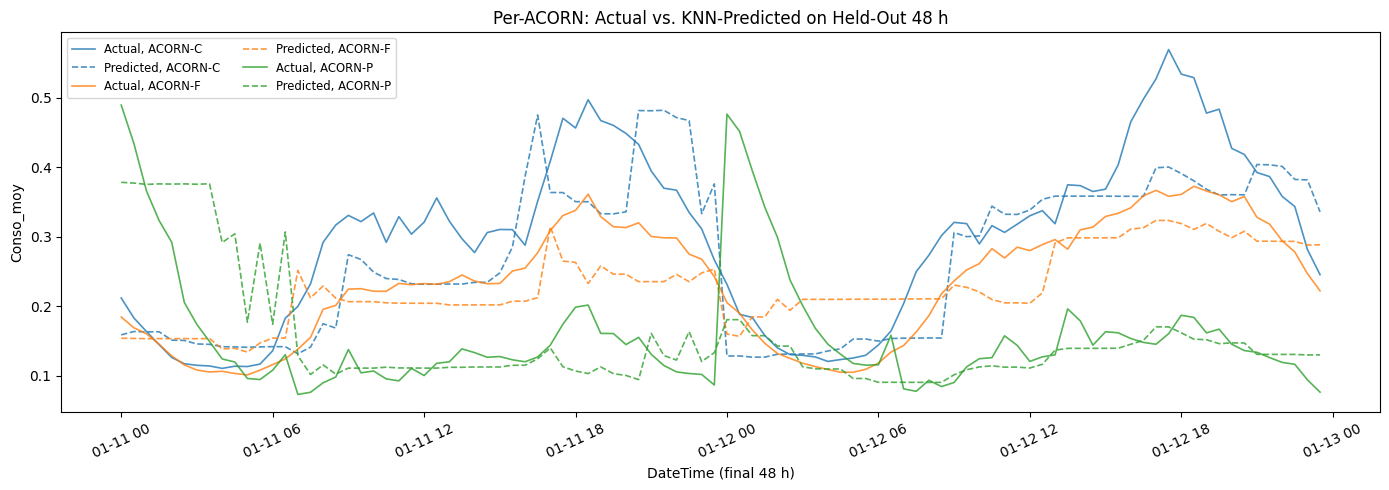

In [130]:
# ──────────────────────────────────────────────────────────────────────────────
# 4) DEFINE FEATURE COLUMNS (DROP “Acorn” FOR PER‐GROUP MODELS)
# ──────────────────────────────────────────────────────────────────────────────
# Numeric features (same as before)
numeric_features = [
    "windBearing", "temperature", "dewPoint", "pressure",
    "windSpeed", "humidity", "nb_clients", "hour", "dayofweek", "month", "dayofyear",
    "is_holiday",
]

# Categorical features (exclude "Acorn" here, since each sub‐DF has a single ACORN)
categorical_features = [
    "precipType",
    "icon",
]

# ──────────────────────────────────────────────────────────────────────────────
# 5) LOOP OVER EACH ACORN TO TRAIN A SEPARATE KNN AND EVALUATE
# ──────────────────────────────────────────────────────────────────────────────
results = {}

for acorn_label in df_train["Acorn"].unique():
    print(f"Training KNN for ACORN = {acorn_label}")

    # 5.1) Extract sub-DataFrames for this ACORN
    sub_train = df_train[df_train["Acorn"] == acorn_label].copy()
    sub_test  = df_test [df_test ["Acorn"] == acorn_label].copy()

    # 5.2) Define X_train_sub, y_train_sub, X_test_sub, y_test_sub
    y_train_sub = sub_train["Conso_moy"].astype(float)
    y_test_sub  = sub_test ["Conso_moy"].astype(float)

    drop_cols = ["Conso_moy", "group_idx", "is_test", "Acorn", "DateTime"]
    X_train_sub = sub_train.drop(columns=drop_cols)
    X_test_sub  = sub_test .drop(columns=drop_cols)

    # 5.3) Build a ColumnTransformer for this group (no “Acorn” in categorical_features)
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ],
        remainder="drop"
    )

    # 5.4) Build a pipeline: Preprocessor → KNN
    knn = KNeighborsRegressor(
        n_neighbors=5,
        weights="distance",
        p=2,
        algorithm="auto",
        leaf_size=30,
        metric="minkowski"
    )
    pipe = Pipeline([
        ("preproc", preprocessor),
        ("knn", knn),
    ])

    # 5.5) Fit on this ACORN’s training data
    pipe.fit(X_train_sub, y_train_sub)

    # 5.6) Predict on this ACORN’s test set
    y_pred_sub = pipe.predict(X_test_sub)

    # 5.7) Compute RMSE / MAE
    rmse_sub = np.sqrt(mean_squared_error(y_test_sub, y_pred_sub))
    mae_sub  = mean_absolute_error(y_test_sub, y_pred_sub)
    mape_sub  = mean_absolute_percentage_error(y_test_sub, y_pred_sub)

    results[acorn_label] = {
        "rmse": rmse_sub,
        "mae": mae_sub,
        "pipe": pipe,
        "X_test": X_test_sub,
        "y_test": y_test_sub.values,
        "y_pred": y_pred_sub,
        "df_test_sub": sub_test,
    }

    print(f"  → Test RMSE = {rmse_sub:.4f}, MAE = {mae_sub:.4f}, MAPE = {100*mape_sub:.4f} %\n")

# ──────────────────────────────────────────────────────────────────────────────
# 6) PLOT EACH ACORN’S HELD‐OUT 48 h (solid = actual, dashed = predicted)
# ──────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(14, 5))

for acorn_label, info in results.items():
    sub_df = info["df_test_sub"].sort_values("DateTime")
    times  = sub_df["DateTime"]
    actual = info["y_test"]
    pred   = info["y_pred"]

    actual_line, = plt.plot(
        times,
        actual,
        label=f"Actual, {acorn_label}",
        linewidth=1.2,
        alpha=0.8
    )
    color = actual_line.get_color()
    plt.plot(
        times,
        pred,
        color=color,
        linestyle="--",
        label=f"Predicted, {acorn_label}",
        linewidth=1.2,
        alpha=0.8
    )

plt.xlabel("DateTime (final 48 h)")
plt.ylabel("Conso_moy")
plt.title("Per-ACORN: Actual vs. KNN‐Predicted on Held‐Out 48 h")
plt.legend(ncol=2, fontsize="small", loc="upper left")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()



In [ ]:
results = {}

for acorn_label in df_train["Acorn"].unique():
    print(f"\n===== TUNING KNN FOR ACORN = {acorn_label} =====")

    # SUBSET THIS ACORN’S TRAIN / TEST DATA
    sub_train = df_train[df_train["Acorn"] == acorn_label].copy().reset_index(drop=True)
    sub_test  = df_test [df_test ["Acorn"] == acorn_label].copy().reset_index(drop=True)

    # EXTRACT X_train_sub, y_train_sub, X_test_sub, y_test_sub
    y_train_sub = sub_train["Conso_moy"].astype(float)
    y_test_sub  = sub_test ["Conso_moy"].astype(float)

    drop_cols = ["Conso_moy", "group_idx", "is_test", "Acorn", "DateTime"]
    X_train_sub = sub_train.drop(columns=drop_cols)
    X_test_sub  = sub_test .drop(columns=drop_cols)

    print(f"  Train rows: {X_train_sub.shape[0]}, Test rows: {X_test_sub.shape[0]}")

    # BUILD A COLUMNTRANSFORMER FOR THIS GROUP (no "Acorn" in categorical_features)
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ],
        remainder="drop"
    )

    # DEFINE OPTUNA OBJECTIVE FOR THIS GROUP
    def objective(trial):
        algorithm = trial.suggest_categorical(
            "algorithm", ["auto", "ball_tree", "kd_tree", "brute"]
        )
        metric = trial.suggest_categorical(
            "metric", ["euclidean", "manhattan", "chebyshev", "minkowski"]
        )
        if metric == "minkowski":
            p = trial.suggest_int("p", 1, 2)
        else:
            p = 2
        n_neighbors = trial.suggest_int("n_neighbors", 1, 100)
        weights     = trial.suggest_categorical("weights", ["uniform", "distance"])
        leaf_size   = trial.suggest_int("leaf_size", 10, 60)

        knn = KNeighborsRegressor(
            n_neighbors=n_neighbors,
            weights=weights,
            algorithm=algorithm,
            leaf_size=leaf_size,
            metric=metric,
            p=p
        )
        pipe = Pipeline([
            ("preproc", preprocessor),
            ("knn", knn),
        ])

        tscv = TimeSeriesSplit(n_splits=3)
        neg_mse = cross_val_score(
            pipe,
            X_train_sub,
            y_train_sub,
            cv=tscv,
            scoring="neg_mean_squared_error",
            n_jobs=-1
        )
        rmse_scores = np.sqrt(-neg_mse)
        return float(rmse_scores.mean())

    # RUN OPTUNA SEARCH FOR THIS ACORN
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50, show_progress_bar=False)

    best_params = study.best_params
    print(f"  → Best params: {best_params}")
    print(f"  → Best CV‐RMSE = {study.best_value:.4f}")

    # REBUILD PIPELINE WITH BEST HYPERPARAMETERS
    best_knn = KNeighborsRegressor(
        n_neighbors=best_params["n_neighbors"],
        weights=best_params["weights"],
        algorithm=best_params["algorithm"],
        leaf_size=best_params["leaf_size"],
        metric=best_params["metric"],
        p=best_params.get("p", 2)
    )
    best_pipe = Pipeline([
        ("preproc", preprocessor),
        ("knn", best_knn),
    ])

    # FIT ON FULL TRAIN SUBSET FOR THIS ACORN
    best_pipe.fit(X_train_sub, y_train_sub)

    # PREDICT ON TEST SUBSET
    y_pred_sub = best_pipe.predict(X_test_sub)

    # COMPUTE RMSE / MAE ON HELD‐OUT 48 h
    rmse_sub = np.sqrt(mean_squared_error(y_test_sub, y_pred_sub))
    mae_sub  = mean_absolute_error(y_test_sub, y_pred_sub)
    mapee_sub  = mean_absolute_percentage_error(y_test_sub, y_pred_sub)
    print(f"  → Held-out 48h Test RMSE = {rmse_sub:.4f}, MAE = {mae_sub:.4f}, MAPE = {100*mape_sub:.4f} %")

    # SAVE RESULTS
    results[acorn_label] = {
        "best_params": best_params,
        "cv_rmse": study.best_value,
        "test_rmse": rmse_sub,
        "test_mae": mae_sub,
        "pipeline": best_pipe,
        "X_test_sub": X_test_sub,
        "y_test_sub": y_test_sub.values,
        "y_pred_sub": y_pred_sub,
        "df_test_sub": sub_test,
    }



[I 2025-06-06 00:36:46,232] A new study created in memory with name: no-name-3f27676f-5250-47be-bd9b-72e0498e89c1



===== TUNING KNN FOR ACORN = ACORN-C =====
  Train rows: 26836, Test rows: 96


[I 2025-06-06 00:36:49,108] Trial 0 finished with value: 0.06900231039974283 and parameters: {'algorithm': 'auto', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 26}. Best is trial 0 with value: 0.06900231039974283.
[I 2025-06-06 00:36:51,696] Trial 1 finished with value: 0.07984265770930661 and parameters: {'algorithm': 'kd_tree', 'metric': 'euclidean', 'n_neighbors': 75, 'weights': 'distance', 'leaf_size': 60}. Best is trial 0 with value: 0.06900231039974283.
[I 2025-06-06 00:36:53,537] Trial 2 finished with value: 0.07976306604969972 and parameters: {'algorithm': 'brute', 'metric': 'euclidean', 'n_neighbors': 91, 'weights': 'distance', 'leaf_size': 50}. Best is trial 0 with value: 0.06900231039974283.
[I 2025-06-06 00:36:56,073] Trial 3 finished with value: 0.0797480047569253 and parameters: {'algorithm': 'brute', 'metric': 'euclidean', 'n_neighbors': 96, 'weights': 'distance', 'leaf_size': 11}. Best is trial 0 with value: 0.06900231039974283.
[

  → Best params: {'algorithm': 'brute', 'metric': 'manhattan', 'n_neighbors': 25, 'weights': 'distance', 'leaf_size': 30}
  → Best CV‐RMSE = 0.0641
  → Held-out 48h Test RMSE = 0.0512, MAE = 0.0410, MAPE = 30.8348 %

===== TUNING KNN FOR ACORN = ACORN-F =====
  Train rows: 26836, Test rows: 96


[I 2025-06-06 00:38:25,704] Trial 0 finished with value: 0.06515961576816859 and parameters: {'algorithm': 'kd_tree', 'metric': 'chebyshev', 'n_neighbors': 49, 'weights': 'uniform', 'leaf_size': 22}. Best is trial 0 with value: 0.06515961576816859.
[I 2025-06-06 00:38:27,387] Trial 1 finished with value: 0.04520782227912553 and parameters: {'algorithm': 'brute', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 68, 'weights': 'distance', 'leaf_size': 37}. Best is trial 1 with value: 0.04520782227912553.
[I 2025-06-06 00:38:30,203] Trial 2 finished with value: 0.06374266108103151 and parameters: {'algorithm': 'brute', 'metric': 'chebyshev', 'n_neighbors': 61, 'weights': 'distance', 'leaf_size': 19}. Best is trial 1 with value: 0.04520782227912553.
[I 2025-06-06 00:38:31,307] Trial 3 finished with value: 0.05459668912301981 and parameters: {'algorithm': 'kd_tree', 'metric': 'euclidean', 'n_neighbors': 26, 'weights': 'uniform', 'leaf_size': 48}. Best is trial 1 with value: 0.04520782227912553

  → Best params: {'algorithm': 'kd_tree', 'metric': 'manhattan', 'n_neighbors': 48, 'weights': 'distance', 'leaf_size': 24}
  → Best CV‐RMSE = 0.0449
  → Held-out 48h Test RMSE = 0.0448, MAE = 0.0370, MAPE = 30.8348 %

===== TUNING KNN FOR ACORN = ACORN-P =====
  Train rows: 26836, Test rows: 96


[I 2025-06-06 00:39:48,371] Trial 0 finished with value: 0.0677649421499057 and parameters: {'algorithm': 'kd_tree', 'metric': 'chebyshev', 'n_neighbors': 38, 'weights': 'distance', 'leaf_size': 51}. Best is trial 0 with value: 0.0677649421499057.
[I 2025-06-06 00:39:49,188] Trial 1 finished with value: 0.06533480302654095 and parameters: {'algorithm': 'auto', 'metric': 'minkowski', 'p': 2, 'n_neighbors': 91, 'weights': 'distance', 'leaf_size': 25}. Best is trial 1 with value: 0.06533480302654095.
[I 2025-06-06 00:39:50,527] Trial 2 finished with value: 0.06823492316532499 and parameters: {'algorithm': 'kd_tree', 'metric': 'chebyshev', 'n_neighbors': 56, 'weights': 'uniform', 'leaf_size': 31}. Best is trial 1 with value: 0.06533480302654095.
[I 2025-06-06 00:39:52,036] Trial 3 finished with value: 0.060073730359027654 and parameters: {'algorithm': 'brute', 'metric': 'minkowski', 'p': 1, 'n_neighbors': 86, 'weights': 'uniform', 'leaf_size': 28}. Best is trial 3 with value: 0.06007373035

  → Best params: {'algorithm': 'brute', 'metric': 'manhattan', 'n_neighbors': 25, 'weights': 'distance', 'leaf_size': 41}
  → Best CV‐RMSE = 0.0593
  → Held-out 48h Test RMSE = 0.0596, MAE = 0.0377, MAPE = 30.8348 %


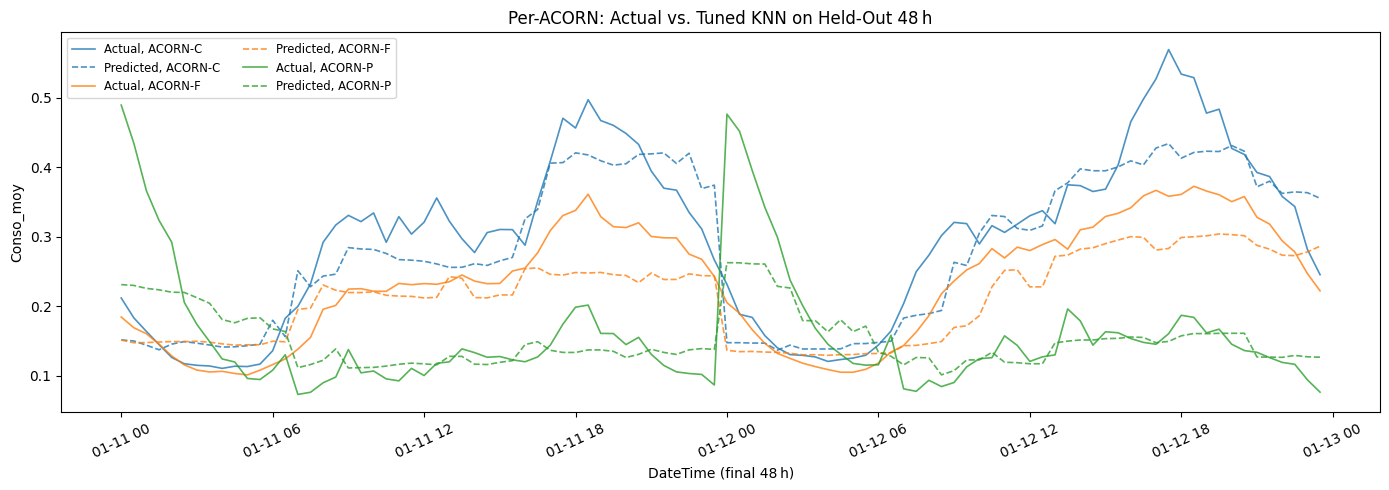

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# OPTIONAL: PLOT HELD‐OUT 48 h FOR EACH ACORN
# ──────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(14, 5))
for acorn_label, info in results.items():
    sub_df = info["df_test_sub"].sort_values("DateTime")
    times  = sub_df["DateTime"]
    actual = info["y_test_sub"]
    pred   = info["y_pred_sub"]

    actual_line, = plt.plot(
        times,
        actual,
        label=f"Actual, {acorn_label}",
        linewidth=1.2,
        alpha=0.8
    )
    color = actual_line.get_color()
    plt.plot(
        times,
        pred,
        color=color,
        linestyle="--",
        label=f"Predicted, {acorn_label}",
        linewidth=1.2,
        alpha=0.8
    )

plt.xlabel("DateTime (final 48 h)")
plt.ylabel("Conso_moy")
plt.title("Per-ACORN: Actual vs. Tuned KNN on Held-Out 48 h")
plt.legend(ncol=2, fontsize="small", loc="upper left")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()



--- Permutation Importances for ACORN = ACORN-P ---
Top 10 features (by mean importance):
  hour             mean = 0.6273,  std = 0.0863
  icon             mean = 0.1037,  std = 0.0317
  precipType       mean = 0.0477,  std = 0.0072
  pressure         mean = 0.0287,  std = 0.0212
  dewPoint         mean = 0.0201,  std = 0.0129
  humidity         mean = 0.0122,  std = 0.0289
  temperature      mean = 0.0109,  std = 0.0090
  dayofyear        mean = 0.0004,  std = 0.0010
  month            mean = 0.0000,  std = 0.0000
  day_of_week      mean = 0.0000,  std = 0.0000


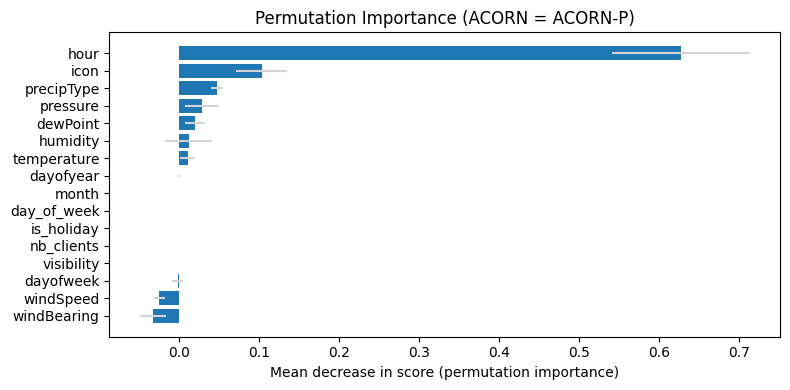

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance


# Compute permutation importance (this permutes each column of X_test_sub):
r = permutation_importance(
    best_pipe,
    X_test_sub,
    y_test_sub,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Use the original column names from X_test_sub:
feature_names = list(X_test_sub.columns)
n_features    = len(feature_names)

# Sanity check (must match)
assert n_features == r.importances_mean.shape[0], (
    f"Feature-count mismatch: {n_features} columns vs. {r.importances_mean.shape[0]} importances"
)

# Sort by descending mean importance:
importances_mean = r.importances_mean
importances_std  = r.importances_std
idx_sorted = np.argsort(importances_mean)[::-1]

# Print the top 10 most important original features:
print(f"\n--- Permutation Importances for ACORN = {acorn_label} ---")
print("Top 10 features (by mean importance):")
for i in idx_sorted[:10]:
    name = feature_names[i]
    mean_imp = importances_mean[i]
    std_imp  = importances_std[i]
    print(f"  {name:<15}  mean = {mean_imp:0.4f},  std = {std_imp:0.4f}")

# Plot all importances in a horizontal bar chart:
plt.figure(figsize=(8, n_features * 0.25))
plt.barh(
    np.arange(n_features),
    importances_mean[idx_sorted],
    xerr=importances_std[idx_sorted],
    align="center",
    color="C0",
    ecolor="lightgray"
)
plt.yticks(np.arange(n_features), np.array(feature_names)[idx_sorted])
plt.gca().invert_yaxis()
plt.xlabel("Mean decrease in score (permutation importance)")
plt.title(f"Permutation Importance (ACORN = {acorn_label})")
plt.tight_layout()
plt.show()



--- Permutation Importances for ACORN = ACORN-P ---
Top 10 features (by mean importance):
  hour             mean = 0.0316,  std = 0.0036
  icon             mean = 0.0063,  std = 0.0018
  precipType       mean = 0.0030,  std = 0.0004
  pressure         mean = 0.0018,  std = 0.0013
  dewPoint         mean = 0.0013,  std = 0.0008
  humidity         mean = 0.0007,  std = 0.0018
  temperature      mean = 0.0007,  std = 0.0006
  dayofyear        mean = 0.0000,  std = 0.0001
  month            mean = 0.0000,  std = 0.0000
  day_of_week      mean = 0.0000,  std = 0.0000


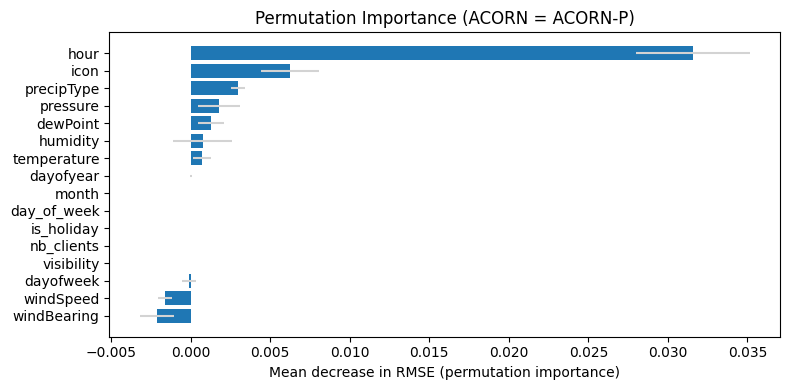

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# ──────────────────────────────────────────────────────────────────────────────
# ASSUMPTIONS: 
#  • best_pipe   = results[acorn_label]["pipeline"]
#  • X_test_sub  = results[acorn_label]["X_test_sub"]   (a pandas DataFrame)
#  • y_test_sub  = results[acorn_label]["y_test_sub"]   (a 1D NumPy array or Series)
#  • df_test_sub = results[acorn_label]["df_test_sub"]  (to get "DateTime" if needed)
# ──────────────────────────────────────────────────────────────────────────────

# 1) Compute permutation importance (this permutes each column of X_test_sub):
r = permutation_importance(
    best_pipe,
    X_test_sub,
    y_test_sub,
    scoring='neg_root_mean_squared_error',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# 2) Use the original column names from X_test_sub:
feature_names = list(X_test_sub.columns)
n_features    = len(feature_names)

# 3) Sanity check (must match)
assert n_features == r.importances_mean.shape[0], (
    f"Feature-count mismatch: {n_features} columns vs. {r.importances_mean.shape[0]} importances"
)

# 4) Sort by descending mean importance:
importances_mean = r.importances_mean
importances_std  = r.importances_std
idx_sorted = np.argsort(importances_mean)[::-1]

# 5) Print the top 10 most important original features:
print(f"\n--- Permutation Importances for ACORN = {acorn_label} ---")
print("Top 10 features (by mean importance):")
for i in idx_sorted[:10]:
    name = feature_names[i]
    mean_imp = importances_mean[i]
    std_imp  = importances_std[i]
    print(f"  {name:<15}  mean = {mean_imp:0.4f},  std = {std_imp:0.4f}")

# 6) Plot all importances in a horizontal bar chart:
plt.figure(figsize=(8, n_features * 0.25))
plt.barh(
    np.arange(n_features),
    importances_mean[idx_sorted],
    xerr=importances_std[idx_sorted],
    align="center",
    color="C0",
    ecolor="lightgray"
)
plt.yticks(np.arange(n_features), np.array(feature_names)[idx_sorted])
plt.gca().invert_yaxis()
plt.xlabel("Mean decrease in RMSE (permutation importance)")
plt.title(f"Permutation Importance (ACORN = {acorn_label})")
plt.tight_layout()
plt.show()

Plotting last 7 days for ACORN = ACORN-C


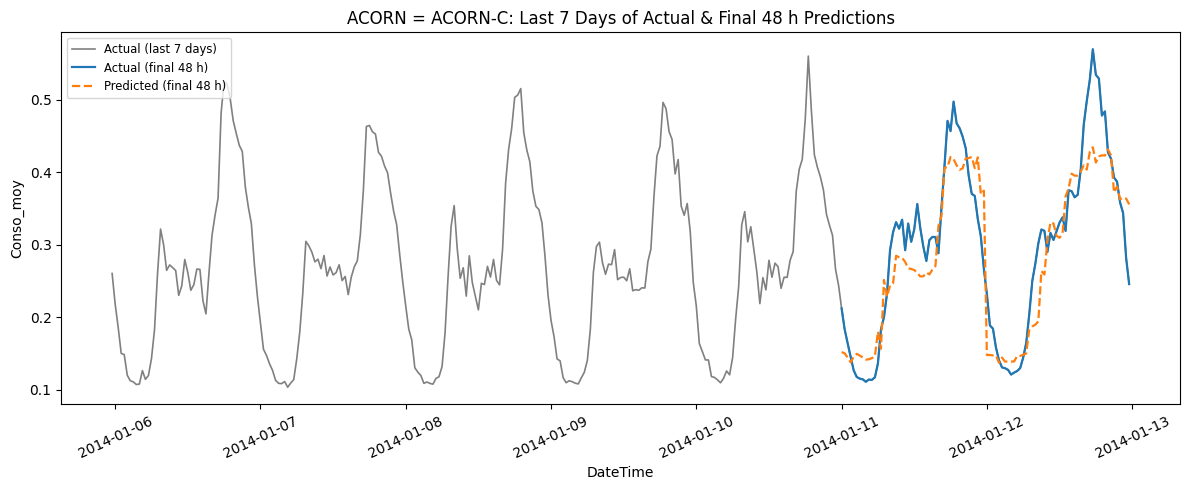

Plotting last 7 days for ACORN = ACORN-F


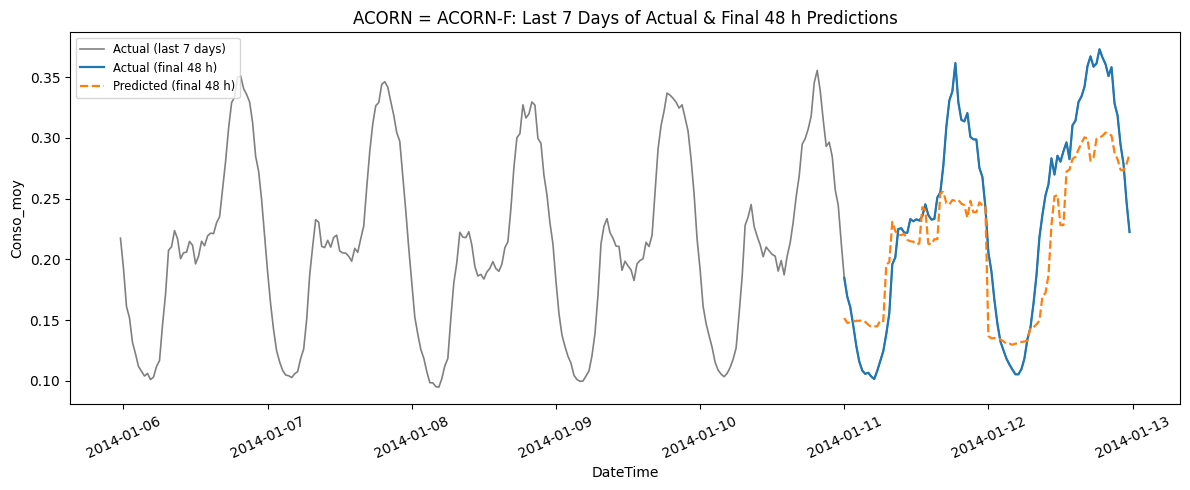

Plotting last 7 days for ACORN = ACORN-P


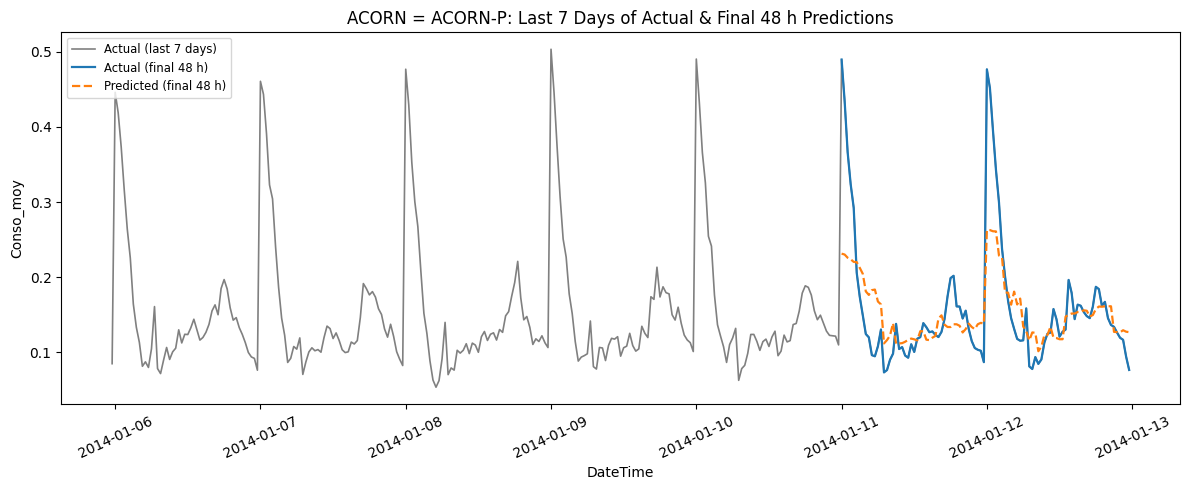

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ──────────────────────────────────────────────────────────────────────────────
# ASSUMPTIONS:
#  • You have a DataFrame `df` containing the full history with columns:
#       ["Acorn", "DateTime", "Conso_moy", … other features …]
#    where "DateTime" is a pandas datetime64[ns] and "Conso_moy" is the actual load.
#
#  • You have a dictionary `results` (from the per‐ACORN tuning loop) where, for each ACORN:
#       results[acorn_label]["df_test_sub"]  = the DataFrame of that ACORN’s last 48h (96 rows),
#                                               including columns ["DateTime", "Conso_moy" …]
#       results[acorn_label]["y_pred_sub"]   = a NumPy array (length 96) of predictions
#
#    In other words, for each `acorn_label`:
#       sub_test = results[acorn_label]["df_test_sub"]  # has “DateTime” + “Conso_moy”
#       y_pred   = results[acorn_label]["y_pred_sub"]   # array of predicted Conso_moy on those same timestamps
#
#  • You want to plot, for each ACORN, the last 7 days (168 hours = 336 half‐hour rows) of actual “Conso_moy”,
#    and then overlay the model’s predictions for the final 48 hours (96 rows).
# ──────────────────────────────────────────────────────────────────────────────

# Loop over each ACORN group
for acorn_label in df["Acorn"].unique():
    print(f"Plotting last 7 days for ACORN = {acorn_label}")
    
    # 1) Full‐history sub‐DataFrame for this ACORN, sorted by DateTime
    full_group = df[df["Acorn"] == acorn_label].sort_values("DateTime").reset_index(drop=True)
    
    # 2) Determine the timestamp one week before the very last timestamp for this group
    last_timestamp = full_group["DateTime"].max()
    one_week_ago = last_timestamp - pd.Timedelta(days=7)
    
    # 3) Filter to only the last 7 days of actual consumption
    last_week_df = full_group[full_group["DateTime"] >= one_week_ago].reset_index(drop=True)
    
    # 4) Extract that ACORN’s final‐48h test‐subset and predictions
    sub_test = results[acorn_label]["df_test_sub"].sort_values("DateTime").reset_index(drop=True)
    y_pred   = results[acorn_label]["y_pred_sub"]
    
    # Sanity check: sub_test must have exactly 96 rows
    # (96 half‐hour rows = final 48 hours)
    assert len(sub_test) == 96, f"Expected 96 rows in {acorn_label} sub_test but got {len(sub_test)}"
    
    # 5) Build a figure for this ACORN
    plt.figure(figsize=(12, 5))
    
    # 5A) Plot actual consumption for the last 7 days
    plt.plot(
        last_week_df["DateTime"],
        last_week_df["Conso_moy"],
        label="Actual (last 7 days)",
        color="gray",
        linewidth=1.2
    )
    
    # 5B) Overlay the actual final 48 h in bold (since they lie in the last 7 days)
    plt.plot(
        sub_test["DateTime"],
        sub_test["Conso_moy"],
        label="Actual (final 48 h)",
        color="C0",
        linewidth=1.6
    )
    
    # 5C) Overlay the predicted final 48 h (dashed)
    plt.plot(
        sub_test["DateTime"],
        y_pred,
        label="Predicted (final 48 h)",
        color="C1",
        linestyle="--",
        linewidth=1.6
    )
    
    # 6) Formatting
    plt.xlabel("DateTime")
    plt.ylabel("Conso_moy")
    plt.title(f"ACORN = {acorn_label}: Last 7 Days of Actual & Final 48 h Predictions")
    plt.legend(loc="upper left", fontsize="small")
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()
